Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.316156
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.303175
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.314214
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.317336
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.301905
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.274860
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.312823
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.310921
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.300413
Train Epoch: 1 [5760/50000 (12%)]	Loss: 2.298556
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.289032
Train Epoch: 1 [7040/50000 (14%)]	Loss: 2.281180
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.286341
Train Epoch: 1 [8320/50000 (17%)]	Loss: 2.288216
Train Epoch: 1 [8960/50000 (18%)]	Loss: 2.268875
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.297248
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.260878
Train Epoch: 1 [10880/50000 (22%)]	Loss: 2.261347
Train Epoch: 1 [11520/50000 (23%)]	Loss: 2.244238
Tr

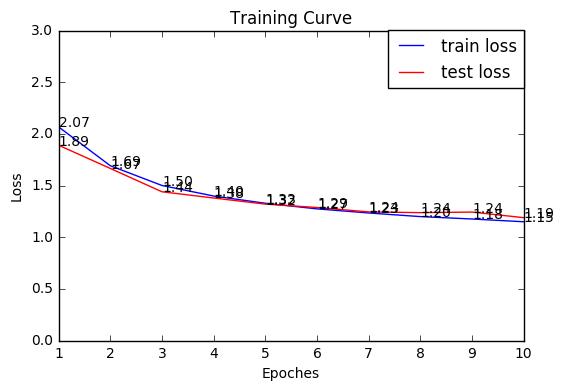

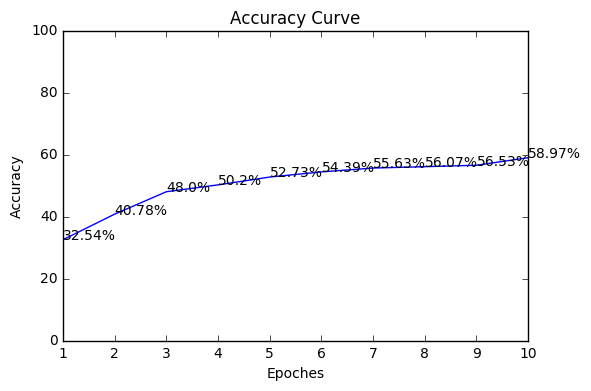

RuntimeError: size mismatch at /data/users/soumith/miniconda2/conda-bld/pytorch-0.1.10_1488753987449/work/torch/lib/THC/generic/THCTensorMathBlas.cu:241

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import math
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# Training settings
# for terminal use. In notebook, you can't parse arguments
class args:
    cuda = False
    batch_size = 64
    test_batch_size = 1000
    epochs = 10
    lr = 0.01
    momentum = 0.5
    no_cuda = False
    seed = 1
    log_interval = 10
    # if add Dropout
    with_dropout = False
    # if initialize weights
    with_init_weights = False
    # if add BatchNorm
    with_batchnorm = False

args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO: define your network here
        self.conv_1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        # TODO: replace fc with conv
        self.fc_1 = nn.Linear(16 * 25, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, 10)
        if args.with_batchnorm:
            self.block_conv_1 = nn.Sequential(
                self.conv_1,
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.block_conv_2 = nn.Sequential(
                self.conv_2,
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        else:
            self.block_conv_1 = nn.Sequential(
                self.conv_1,
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.block_conv_2 = nn.Sequential(
                self.conv_2,
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        if args.with_dropout:
            if args.with_batchnorm:
                self.block_fc_1 = nn.Sequential(
                    self.fc_1,
                    nn.BatchNorm1d(120),
                    nn.Dropout()
                )
                self.block_fc_2 = nn.Sequential(
                    self.fc_2,
                    nn.BatchNorm1d(84),
                    nn.Dropout()
                )
            else:
                self.block_fc_1 = nn.Sequential(
                    self.fc_1,
                    nn.Dropout()
                )
                self.block_fc_2 = nn.Sequential(
                    self.fc_2,
                    nn.Dropout()
                )
        else:
            self.block_fc_1 = self.fc_1
            self.block_fc_2 = self.fc_2
        self.softmax = nn.LogSoftmax()
        # Initialize parameters
        if args.with_init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. /n))
                    if m.bias is not None:
                        m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    n = m.out_features
                    m.weight.data.normal_(0, math.sqrt(2. /n))
                    if m.bias is not None:
                        m.bias.data.zero_()
                elif isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()

    def forward(self, x):
        # TODO
        x = self.block_conv_1(x)
        x = self.block_conv_2(x)
        x = x.view(x.size(0), -1)
        x = self.block_fc_1(x)
        x = self.block_fc_2(x)
        x = self.fc_3(x)
        x = self.softmax(x)
        return x

# Feature extractor for filter visualization
class FeatureExtractor(nn.Module):
    def __init__(self, model, layer_names):
        super(FeatureExtractor, self).__init__()
        self._model = model
        self._layer_names = set(layer_names)

    def forward(self, x):
        out = dict()
        # _modules is an OrderedDict, which replace iteritems() with items() in python3.* 
        for name, module in self._model._modules.items():
            if isinstance(module, nn.Linear):
                x = x.view(x.size(0), -1)
            x = module(x)
            if name in self._layer_names:
                out[name] = x
        return out

# Vesualize training results and trained filters
class VisualizedResult():
    def __init__(self, model):
        self._model = model
    def training_curve(self, epoches, train_loss_records, test_loss_records):
        fig = plt.figure()
        ax_train = fig.add_subplot(111)
        ax_test = fig.add_subplot(111)
        plt.axis([1, epoches, 0, math.ceil(max(train_loss_records + test_loss_records) * 1.2)])
        plt.xlabel('Epoches')
        plt.ylabel('Loss')
        plt.title('Training Curve')
        plt.plot(range(1, epoches + 1), train_loss_records, 'b-', label="train loss")
        plt.plot(range(1, epoches + 1), test_loss_records, 'r-', label="test loss")
        for xy in zip(range(1, epoches + 1), train_loss_records):
            ax_train.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
        for xy in zip(range(1, epoches + 1), test_loss_records):
            ax_test.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
        plt.legend(loc='upper right', borderaxespad=0.)
        plt.show()
    def accuracy_curve(self, epoches, accuracy_records):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.axis([1, epoches, 0, 100])
        plt.xlabel('Epoches')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curve')
        plt.plot(range(1, epoches + 1), accuracy_records, '-')
        for xy in zip(range(1, epoches + 1), accuracy_records):
            ax.annotate('%s%%' % xy[1], xy=xy, textcoords='data')
        plt.show()
    def conv_filter(self, layer_names):
        model.eval()
        feature_extractor = FeatureExtractor(self._model, layer_names)
        for data, target in test_loader:
            if args.cuda:
                data = data.cuda()
            data = Variable(data, volatile=True)
        out = feature_extractor.forward(data)
        print(out)


model = Net()
if args.cuda:
    model.cuda()
    
# TODO: other optimizers
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

train_loss_records = list()
test_loss_records = list()
accuracy_records = list()

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)   # is it true to use such a loss over cross-entropy loss? 
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    # Average training loss for this epoch
    train_loss_records.append(train_loss / len(train_loader))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    test_loss_records.append(test_loss)
    accuracy_records.append(accuracy)


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)

visual_result = VisualizedResult(model)
# Visualize training curve
visual_result.training_curve(args.epochs, train_loss_records, test_loss_records)
# Visualize test accuracy
visual_result.accuracy_curve(args.epochs, accuracy_records)
# Visualize trained filter on the 1st Conv layer
visual_result.conv_filter(['conv_1'])
